In [1]:
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


## only depth

In [2]:
# from share import *
# import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################


def show_image(img, detect_resolution=512):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    input_image_np = img

    rgb_image =resize_image(input_image_np, detect_resolution)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    return tiff_np_uint8,tiff_pil_uint8


inputs_np=gr.Image(type="numpy")


demo = gr.Interface(
    fn=show_image, 
    inputs=gr.Image(type="numpy"), 
    outputs=[gr.Image(type="numpy"),
             gr.Image(type="pil"),
            ]
)
    
# demo.launch(share=True)
demo.launch()

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## depth + corrosion -> 结合深度预测，应用腐蚀的mask进行腐蚀生成包含功能：
### ** 注意此版本gradio问题，左边原图框输入图片后，在右边的绘图取先点击画笔，再点击upload，才能upload成功，否则会报错。
### 1. 结合深度预测+现有mask，生成腐蚀 （2024.9.12完成）
### 2. 结合深度预测+绘制mask，生成腐蚀 （2024.9.12完成）
### 3. 结合深度预测+构件检测+绘制mask，生成腐蚀 （未完成）

In [1]:
## 这个只有绘制腐蚀和腐蚀贴图
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################

######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil

# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
#                 "rgb(128, 0, 0)", # fair
#                 "rgb(0, 128, 0)", # poor
#                 "rgb(128, 128, 0)",] # severe
brush_colors.colors=[
                "rgb(0, 128, 0)", # poor
                # "rgb(128, 0, 0)", # fair
                # "rgb(128, 128, 0)",
                ] # severe

# brush_colors.colors=[
                
#                 "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
         # with gr.Blocks():
        with gr.Group():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 3")
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(0, 128, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fae80487eb0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fae80462bb0>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.25it/s]


In [1]:
## 这个只有绘制腐蚀和腐蚀贴图
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################

######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil

# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
#                 "rgb(128, 0, 0)", # fair
#                 "rgb(0, 128, 0)", # poor
#                 "rgb(128, 128, 0)",] # severe
# brush_colors.colors=[
#                 "rgb(0, 128, 0)", # poor
#                 "rgb(128, 0, 0)", # fair
#                 "rgb(128, 128, 0)",] # severe

brush_colors.colors=[
                
                "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
         # with gr.Blocks():
        with gr.Group():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 3")
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(128, 128, 0)', 'rgb(0, 128, 0)', 'rgb(128, 0, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f7d436c3f10>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f7d43663070>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


im: {'background': array([[[ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        ...,
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255]],

       [[ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        ...,
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255]],

       [[ 24,  40,  26, 255],
        [ 24,  40,  26, 255],
        [ 24,  40,  26, 255],
        ...,
        [ 46,  73,  48, 255],
        [ 46,  73,  48, 255],
        [ 46,  73,  48, 255]],

       ...,

       [[122, 120, 103, 255],
        [124, 123, 105, 255],
        [129, 127, 110, 255],
        ...,
        [ 88,  91,  86, 255],
        [ 87,  90,  84, 255],
        [ 85,  88,  82, 255]],

       [[118, 117,  99, 255],
        [130, 128, 111, 255],
        [141, 139, 121, 255],
        ...,
        [ 93,  96,  90, 255],
        [ 92,  95,  89, 255],
        [ 90,  94,  88, 2

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: DDPM


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.66it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: DDIM


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        ...,
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255]],

       [[ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        [ 23,  39,  25, 255],
        ...,
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255],
        [ 45,  71,  46, 255]],

       [[ 24,  40,  26, 255],
        [ 24,  40,  26, 255],
        [ 24,  40,  26, 255],
        ...,
        [ 46,  73,  48, 255],
        [ 46,  73,  48, 255],
        [ 46,  73,  48, 255]],

       ...,

       [[122, 120, 103, 255],
        [124, 123, 105, 255],
        [129, 127, 110, 255],
        ...,
        [ 88,  91,  86, 255],
        [ 87,  90,  84, 255],
        [ 85,  88,  82, 255]],

       [[118, 117,  99, 255],
        [130, 128, 111, 255],
        [141, 139, 121, 255],
        ...,
        [ 

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: DDIM


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.77it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PSNR


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


im: {'background': array([[[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [105,  88,  67, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       ...,

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [253, 255, 231, 255],
        [254, 255, 232, 255],
        [254, 255, 232, 255]],

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [250, 251, 230, 255],
        [250, 251, 230, 255],
        [250, 251, 230, 2

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PSNR


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.21it/s]


In [1]:
## 这个只有绘制腐蚀和腐蚀贴图
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################

######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil

# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
#                 "rgb(128, 0, 0)", # fair
#                 "rgb(0, 128, 0)", # poor
#                 "rgb(128, 128, 0)",] # severe
brush_colors.colors=[
                "rgb(0, 128, 0)", # poor
                "rgb(128, 0, 0)", # fair
                "rgb(128, 128, 0)",] # severe

# brush_colors.colors=[
                
#                 "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
         # with gr.Blocks():
        with gr.Group():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 3")
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(0, 128, 0)', 'rgb(128, 0, 0)', 'rgb(128, 128, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f4730208a60>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f47301faee0>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


im: {'background': array([[[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [105,  88,  67, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       ...,

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [253, 255, 231, 255],
        [254, 255, 232, 255],
        [254, 255, 232, 255]],

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [250, 251, 230, 255],
        [250, 251, 230, 255],
        [250, 251, 230, 2

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


im: {'background': array([[[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [104,  87,  65, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       [[104,  87,  65, 255],
        [104,  87,  65, 255],
        [105,  88,  67, 255],
        ...,
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255],
        [ 65,  63,  48, 255]],

       ...,

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [253, 255, 231, 255],
        [254, 255, 232, 255],
        [254, 255, 232, 255]],

       [[124,  75,  66, 255],
        [124,  75,  66, 255],
        [118,  69,  60, 255],
        ...,
        [250, 251, 230, 255],
        [250, 251, 230, 255],
        [250, 251, 230, 2

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀生成。

In [1]:
## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀生成。
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt
from collections import Counter  



onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"
onnx_seg_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx'
def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth


def merge_org_with_mask_for_org_mask(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil

def merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil
################################
# 1.用训练好的构件识别模型进行分割
################################



###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
################################
# 1.定义分割构件和生成椭圆的函数
################################
from PIL import Image, ImageDraw
import random
from torchvision import transforms
import numpy as np
import onnx
import onnxruntime as ort
import cv2
import torch
from matplotlib import pyplot as plt
# from dataset.semi import normalize
from PIL import Image
from torchvision import transforms
import imgviz



def normalize(img, mask=None):
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    if mask is not None:
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask
    return img


def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

## 分割构件
def seg_members(onnx_dir, img_pil):
    # 加载模型
    img_input = normalize(img_pil)
    # 对于onnx需要指定输入的shape
    resize = transforms.Resize([512,512])
    img_input = resize(img_input)
    print(img_input.shape)
    # img_tensor = torch.from_numpy(img_input).type(torch.cuda.FloatTensor)
    img_tensor = img_input.unsqueeze(0).cuda()
    img_np = img_tensor.detach().cpu().numpy()
    print(img_np.shape)
    ort_session = ort.InferenceSession(onnx_dir) # 创建一个推理session

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}

    import time
    start = time.time()
    ort_outs = ort_session.run(None, ort_inputs)[0]
    # 通过 get_inputs()[i].name来获取输入的名称
    end = time.time()
    print("onnx预测时间：", end-start)
    print(ort_outs.shape,  type(ort_outs))
    # print(ort_outs)

    # 输出为4分类，即，c=4的图像，取最大的通道，合并，即为预测图像
    # numpy转torch
    pred = torch.from_numpy(ort_outs)
    pred_softmax = pred.softmax(dim=1).max(dim=1)[1]
    print(pred_softmax.shape)
    # print(pred_softmax)

    pred_np = pred_softmax.numpy()[0]
    # 对预测的mask用colored_mask上色
    pred_pil_np = colored_mask(pred_np)
    pred_np_cls = np.unique(pred_np)
    
    return pred_pil_np, pred_np_cls


###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
def generate_ellipse_to_want_area(org_img_np, generate_ellipses, fill_value, want_area = [1,4], num_ellipses=25, a_min=30, a_max=100, b_min=20, b_max=40, split_everywhere=False):
    """
    generate_ellipsepolygon_to_want_area based on function 'generate_polygon'.

    Args:
        org_img_np (numpy.ndarray): The input array.
        generate_polygon (function): generate_polygon
        want_area_list (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1,4].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled polygon.
    """
    fill_value = severe_dict[fill_value]
    # 选择腐蚀类型
    # corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
    list_area_corrosion = []
    list_area_only_corrosion = []
    for area in want_area:
        gen_polygon, gen_polygon_blank = generate_ellipses(arr=org_img_np, fill_value=fill_value, values=area, num_ellipses=num_ellipses, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, split_everywhere=split_everywhere)
        list_area_corrosion.append(gen_polygon)
        list_area_only_corrosion.append(gen_polygon_blank)
    sum_area = np.sum(list_area_corrosion, axis=0)
    sum_area_only_corrosion = np.sum(list_area_only_corrosion, axis=0)
    return sum_area, list_area_corrosion, sum_area_only_corrosion, list_area_only_corrosion

########### 定义基于numpy选择构件的函数#####

def filter_array(arr, values):
    """
    Filter a NumPy array to keep only the specified values.

    Args:
        arr (numpy.ndarray): The input array to be filtered.
        values (list or tuple): A list or tuple of values to keep in the filtered array.

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing only the specified values.
    """
    conditions = [arr == value for value in values]
    condition = np.logical_or.reduce(conditions)
    filtered_arr = np.where(condition, arr, 0)
    return filtered_arr

################### 选择腐蚀类型 ######################
# corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
def corrosionType_to_fill_value(corrosionType):
    fill_value = []
    for i in corrosionType:
        if i==1:
            fill_value.append(12)
        elif i==2:
            fill_value.append(6)
        elif i==3:
            fill_value.append(4)
    return fill_value

# fill_value_list = corrosionType_to_fill_value(corrosionType=corrosionType) # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： 1-fair对应12/12，2-poor对应12/6， 3-severe对应12/4


################### 定义和生成椭圆 ######################
def generate_ellipses(arr, fill_value=1, values=[5], num_ellipses=5, a_min=30, a_max=120, b_min=10, b_max=80, split_everywhere=True):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        tuple(numpy.ndarray): A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    
    selected_region = np.isin(arr, values)
    # print(selected_region)
    selected_coords = np.argwhere(selected_region)
    print('可选的坐标点数：',len(selected_coords))
    # # 椭圆数量和范围
    # num_ellipses = 5
    # a_min, a_max = 20, 50
    # b_min, b_max = 10, 30
    
    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)
    # # 生成图片
    # im = Image.new('RGB', (100,100), color='white')  
    # draw = ImageDraw.Draw(im)
    if split_everywhere:
        for i in range(num_ellipses):
            xy_arr = random.sample(list(selected_coords), k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)
    else:
        selected_coords_with_according_to_num_ellipses_list = []
        xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
        selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
        count_num = 0
        for i in list(selected_coords):
            dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
            if dist<= (a_max + b_max):
                selected_coords_with_according_to_num_ellipses_list.append(i)
                xy_arr_0 = i
                count_num += 1
                # print(count_num)
                # print('a')
                if count_num == num_ellipses*3:
                    break
            
        
        # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
        for i in range(num_ellipses):
            xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            # print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)

            
    
    return result, result_mask




######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    # merged_org_img_with_mask_pil = merge_org_with_mask_for_org_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    # merged_org_img_with_mask_pil = merge_org_with_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_members_seg(org_img,  prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024,split_everywhere = False, fill_value_setting = 'poor', num_ellipse='15' ):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    # seg members->分割构件
    # 定义numpy的随机模式
    np.random.seed(seed)
    random.seed(seed)
    pred_pil, pred_np_cls = seg_members(onnx_dir='/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx', 
                                       img_pil=org_rgb_image_pil)
    print(np.array(pred_pil), pred_np_cls)
    mask_members_np_mode_R = np.array(pred_pil)
    # select_area_list = [np.random.choice(pred_np_cls[1:])]
    print('******* Detected members *******',mask_members_np_mode_R)
    # 选择构件区域
    mask_members_np_mode_R_filter = filter_array(mask_members_np_mode_R, mask_members_np_mode_R)
    print('构件mask的形状和元素值', mask_members_np_mode_R_filter.shape, np.unique(mask_members_np_mode_R_filter))
    ## 找到最大的构件区域
    # max_num_area = np.argmax(np.bincount(mask_members_np_mode_R_filter))
    # 将数组展平成一维数组  
    # flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter.flatten()  
    flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter[mask_members_np_mode_R_filter != 0]
    
    # 使用Counter统计每个元素出现的次数  
    counter = Counter(flattened_mask_members_np_mode_R_filter)  
    
    # 找到出现次数最多的元素及其值  
    most_common_element, count = counter.most_common(1)[0] 
    print('最多出现的元素及其值:', most_common_element, count, members_text_dict[str(most_common_element.tolist())])
    # cv2.imshow('pred_np_cls', mask_members_np_mode_R_filter)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 4.在members指定区域生成任意数量的腐蚀，返回仅仅为腐蚀区域 （生成用）
    num_ellipse = int(num_ellipse)
    mask_corrosion_corr_to_members, mask_corrosion_corr_to_members_list, mask_only_corrosion_corr_to_members, mask_only_corrosion_corr_to_members_list = generate_ellipse_to_want_area(org_img_np=mask_members_np_mode_R, generate_ellipses=generate_ellipses, fill_value=fill_value_setting, want_area=[most_common_element], split_everywhere=split_everywhere, num_ellipses=num_ellipse)
    # plt.imshow(mask_corrosion_corr_to_members)

    # mask_only_corrosion_corr_to_members_devide_by_fill_value = (mask_only_corrosion_corr_to_members/fill_value_setting).astype((np.uint64))
    mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))
    print(mask_only_corrosion_corr_to_members_devide_by_fill_value.min(), mask_only_corrosion_corr_to_members_devide_by_fill_value.max(), np.unique(mask_only_corrosion_corr_to_members_devide_by_fill_value), mask_only_corrosion_corr_to_members_devide_by_fill_value.dtype)
    # print(np.unique(mask_only_corrosion_corr_to_members/12), mask_only_corrosion_corr_to_members.dtype, ((mask_only_corrosion_corr_to_members/12).astype(np.uint64)).dtype)

    mask_only_corrosion_final_pil = colored_mask(mask_only_corrosion_corr_to_members_devide_by_fill_value)
    # cv2.imshow('mask_only_corrosion_final_pil', mask_only_corrosion_final_pil)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 5.在腐蚀区域生成椭圆，返回椭圆区域 （生成用）
    # rgb_image =resize_image(input_image_np, image_resolution)
    # rgb_image_pil = Image.fromarray(rgb_image) 
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    merged_org_img_with_mask_pil = merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil=org_rgb_image_pil, mask_pil=mask_only_corrosion_final_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=merged_org_img_with_mask_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8, pred_pil, mask_only_corrosion_final_pil, merged_org_img_with_mask_pil, out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil



# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
                
#                 "rgb(0, 128, 0)", # poor
                
#                 ] 
brush_colors.colors=[
                
                "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]

# brush_colors.colors=[
                
#                 "rgb(128, 0, 0)","rgb(128, 128, 0)","rgb(0, 128, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

# 设置严重程度字典（这个用于生成椭圆）
severe_dict = {'fair': 12, 'poor': 6,'severe': 4}

members_text_dict = {'1': 'Bearing', '2': 'Bracing','3': 'Deck', '4':'Floor beam','5': 'Girder','6': 'Substructure','7': 'Gusset plate','8': 'Chord'
                     ,'9': 'Vertical ','10': 'Diagonal','11': 'Railing'}
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "There is no such Key"

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 3')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                split_everywhere = gr.Radio(['True', 'False'], label='Split everywhere or not', info='Split everywhere or not', visible=True)
                fill_value_setting = gr.Radio(severe_dict.keys(), label='Fill value setting', info='Fill value setting', visible=True)
                num_ellipse = gr.Textbox(placeholder="How many ellipses do you want to draw?",label="Number of ellipses")
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=5.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_seg_members = gr.Gallery(label='Output segmented members', show_label=True, elem_id="gallery", height='auto')
                # result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, split_everywhere, fill_value_setting, num_ellipse]
        run_button.click(fn=show_image_members_seg, inputs=inputs, outputs=[result_gallery_seg_members])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(128, 128, 0)', 'rgb(0, 128, 0)', 'rgb(128, 0, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fe4c03be1c0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fe4c035e760>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fe4c0373880>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: None
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀以及裂缝生成的功能。

In [1]:
## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀生成。
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt
from collections import Counter  



onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"
onnx_seg_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx'
def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth


def merge_org_with_mask_for_org_mask(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil

def merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil
################################
# 1.用训练好的构件识别模型进行分割
################################



###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
################################
# 1.定义分割构件和生成椭圆的函数
################################
from PIL import Image, ImageDraw
import random
from torchvision import transforms
import numpy as np
import onnx
import onnxruntime as ort
import cv2
import torch
from matplotlib import pyplot as plt
# from dataset.semi import normalize
from PIL import Image
from torchvision import transforms
import imgviz



def normalize(img, mask=None):
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    if mask is not None:
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask
    return img


def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

## 分割构件
def seg_members(onnx_dir, img_pil):
    # 加载模型
    img_input = normalize(img_pil)
    # 对于onnx需要指定输入的shape
    resize = transforms.Resize([512,512])
    img_input = resize(img_input)
    print(img_input.shape)
    # img_tensor = torch.from_numpy(img_input).type(torch.cuda.FloatTensor)
    img_tensor = img_input.unsqueeze(0).cuda()
    img_np = img_tensor.detach().cpu().numpy()
    print(img_np.shape)
    ort_session = ort.InferenceSession(onnx_dir) # 创建一个推理session

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}

    import time
    start = time.time()
    ort_outs = ort_session.run(None, ort_inputs)[0]
    # 通过 get_inputs()[i].name来获取输入的名称
    end = time.time()
    print("onnx预测时间：", end-start)
    print(ort_outs.shape,  type(ort_outs))
    # print(ort_outs)

    # 输出为4分类，即，c=4的图像，取最大的通道，合并，即为预测图像
    # numpy转torch
    pred = torch.from_numpy(ort_outs)
    pred_softmax = pred.softmax(dim=1).max(dim=1)[1]
    print(pred_softmax.shape)
    # print(pred_softmax)

    pred_np = pred_softmax.numpy()[0]
    # 对预测的mask用colored_mask上色
    pred_pil_np = colored_mask(pred_np)
    pred_np_cls = np.unique(pred_np)
    
    return pred_pil_np, pred_np_cls


###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
def generate_ellipse_to_want_area(org_img_np, generate_ellipses, fill_value, want_area = [1,4], num_ellipses=25, a_min=30, a_max=100, b_min=20, b_max=40, split_everywhere=False):
    """
    generate_ellipsepolygon_to_want_area based on function 'generate_polygon'.

    Args:
        org_img_np (numpy.ndarray): The input array.
        generate_polygon (function): generate_polygon
        want_area_list (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1,4].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled polygon.
    """
    fill_value = severe_dict[fill_value]
    # 选择腐蚀类型
    # corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
    list_area_corrosion = []
    list_area_only_corrosion = []
    for area in want_area:
        gen_polygon, gen_polygon_blank = generate_ellipses(arr=org_img_np, fill_value=fill_value, values=area, num_ellipses=num_ellipses, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, split_everywhere=split_everywhere)
        list_area_corrosion.append(gen_polygon)
        list_area_only_corrosion.append(gen_polygon_blank)
    sum_area = np.sum(list_area_corrosion, axis=0)
    sum_area_only_corrosion = np.sum(list_area_only_corrosion, axis=0)
    return sum_area, list_area_corrosion, sum_area_only_corrosion, list_area_only_corrosion

########### 定义基于numpy选择构件的函数#####

def filter_array(arr, values):
    """
    Filter a NumPy array to keep only the specified values.

    Args:
        arr (numpy.ndarray): The input array to be filtered.
        values (list or tuple): A list or tuple of values to keep in the filtered array.

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing only the specified values.
    """
    conditions = [arr == value for value in values]
    condition = np.logical_or.reduce(conditions)
    filtered_arr = np.where(condition, arr, 0)
    return filtered_arr

################### 选择腐蚀类型 ######################
# corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
def corrosionType_to_fill_value(corrosionType):
    fill_value = []
    for i in corrosionType:
        if i==1:
            fill_value.append(12)
        elif i==2:
            fill_value.append(6)
        elif i==3:
            fill_value.append(4)
    return fill_value

# fill_value_list = corrosionType_to_fill_value(corrosionType=corrosionType) # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： 1-fair对应12/12，2-poor对应12/6， 3-severe对应12/4


################### 定义和生成椭圆 ######################
def generate_ellipses(arr, fill_value=1, values=[5], num_ellipses=5, a_min=30, a_max=120, b_min=10, b_max=80, split_everywhere=True):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        tuple(numpy.ndarray): A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    
    selected_region = np.isin(arr, values)
    # print(selected_region)
    selected_coords = np.argwhere(selected_region)
    print('可选的坐标点数：',len(selected_coords))
    # # 椭圆数量和范围
    # num_ellipses = 5
    # a_min, a_max = 20, 50
    # b_min, b_max = 10, 30
    
    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)
    # # 生成图片
    # im = Image.new('RGB', (100,100), color='white')  
    # draw = ImageDraw.Draw(im)
    if split_everywhere:
        for i in range(num_ellipses):
            xy_arr = random.sample(list(selected_coords), k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)
    else:
        selected_coords_with_according_to_num_ellipses_list = []
        xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
        selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
        count_num = 0
        for i in list(selected_coords):
            dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
            if dist<= (a_max + b_max):
                selected_coords_with_according_to_num_ellipses_list.append(i)
                xy_arr_0 = i
                count_num += 1
                # print(count_num)
                # print('a')
                if count_num == num_ellipses*3:
                    break
            
        
        # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
        for i in range(num_ellipses):
            xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            # print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)

            
    
    return result, result_mask




######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,control_strength=1.0
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        
        controlnet_conditioning_scale_list=[control_strength,1.0]
        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image

#######################
# crack
def controlnet_diff_crack(crack_pil, prompt = 'crack on concrete surface',device = 'cuda',seed = 2024,use_freeu = False,control_strength=1.0,
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_crack_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_crack_without_bg_with_prompt_inpainting_h-512_w-512_2024-11-22_13:28:33_seeds-2024/checkpoint-2400/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_crack = ControlNetModel.from_pretrained(control_crack_trained_dir)
 
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_crack], safety_checker=None, iter_times=5).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_crack], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_crack], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_crack_pil = load_image(crack_pil)
        controlnet_conditioning_scale_list=[control_strength,1.0]
        validation_image = [mask_crack_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024, control_strength=1.0):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    # merged_org_img_with_mask_pil = merge_org_with_mask_for_org_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,control_strength=control_strength)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil

def show_image_crack(img, prompt='crack on concrete surface', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024, control_strength=1.0):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    # org_rgb_image =resize_image(org_img, image_resolution)
    # org_rgb_image_pil = Image.fromarray(org_rgb_image)
    masked_image =resize_image(input_image_np, image_resolution)
    masked_image_pil = Image.fromarray(masked_image)
    # tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    # vmin = np.percentile(tiff_np, 2)
    # vmax = np.percentile(tiff_np, 85)
    # # print(vmin, vmax)

    # tiff_np -= vmin
    # tiff_np /= vmax - vmin
    # tiff_np = 1.0 - tiff_np
    # tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    # tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    # merged_org_img_with_mask_pil = merge_org_with_mask_for_org_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff_crack(crack_pil=masked_image_pil, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,control_strength=control_strength)
    
    return [out_control_diff_pil]

def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024, control_strength=1.0):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    # merged_org_img_with_mask_pil = merge_org_with_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,control_strength=control_strength)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_members_seg(org_img,  prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024,split_everywhere = False, fill_value_setting = 'poor', num_ellipse='15', control_strength=1.0 ):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    # seg members->分割构件
    # 定义numpy的随机模式
    np.random.seed(seed)
    random.seed(seed)
    pred_pil, pred_np_cls = seg_members(onnx_dir='/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx', 
                                       img_pil=org_rgb_image_pil)
    print(np.array(pred_pil), pred_np_cls)
    mask_members_np_mode_R = np.array(pred_pil)
    # select_area_list = [np.random.choice(pred_np_cls[1:])]
    print('******* Detected members *******',mask_members_np_mode_R)
    # 选择构件区域
    mask_members_np_mode_R_filter = filter_array(mask_members_np_mode_R, mask_members_np_mode_R)
    print('构件mask的形状和元素值', mask_members_np_mode_R_filter.shape, np.unique(mask_members_np_mode_R_filter))
    ## 找到最大的构件区域
    # max_num_area = np.argmax(np.bincount(mask_members_np_mode_R_filter))
    # 将数组展平成一维数组  
    # flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter.flatten()  
    flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter[mask_members_np_mode_R_filter != 0]
    
    # 使用Counter统计每个元素出现的次数  
    counter = Counter(flattened_mask_members_np_mode_R_filter)  
    
    # 找到出现次数最多的元素及其值  
    most_common_element, count = counter.most_common(1)[0] 
    print('最多出现的元素及其值:', most_common_element, count, members_text_dict[str(most_common_element.tolist())])
    # cv2.imshow('pred_np_cls', mask_members_np_mode_R_filter)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 4.在members指定区域生成任意数量的腐蚀，返回仅仅为腐蚀区域 （生成用）
    num_ellipse = int(num_ellipse)
    mask_corrosion_corr_to_members, mask_corrosion_corr_to_members_list, mask_only_corrosion_corr_to_members, mask_only_corrosion_corr_to_members_list = generate_ellipse_to_want_area(org_img_np=mask_members_np_mode_R, generate_ellipses=generate_ellipses, fill_value=fill_value_setting, want_area=[most_common_element], split_everywhere=split_everywhere, num_ellipses=num_ellipse)
    # plt.imshow(mask_corrosion_corr_to_members)

    # mask_only_corrosion_corr_to_members_devide_by_fill_value = (mask_only_corrosion_corr_to_members/fill_value_setting).astype((np.uint64))
    mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))
    print(mask_only_corrosion_corr_to_members_devide_by_fill_value.min(), mask_only_corrosion_corr_to_members_devide_by_fill_value.max(), np.unique(mask_only_corrosion_corr_to_members_devide_by_fill_value), mask_only_corrosion_corr_to_members_devide_by_fill_value.dtype)
    # print(np.unique(mask_only_corrosion_corr_to_members/12), mask_only_corrosion_corr_to_members.dtype, ((mask_only_corrosion_corr_to_members/12).astype(np.uint64)).dtype)

    mask_only_corrosion_final_pil = colored_mask(mask_only_corrosion_corr_to_members_devide_by_fill_value)
    # cv2.imshow('mask_only_corrosion_final_pil', mask_only_corrosion_final_pil)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 5.在腐蚀区域生成椭圆，返回椭圆区域 （生成用）
    # rgb_image =resize_image(input_image_np, image_resolution)
    # rgb_image_pil = Image.fromarray(rgb_image) 
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    merged_org_img_with_mask_pil = merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil=org_rgb_image_pil, mask_pil=mask_only_corrosion_final_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=merged_org_img_with_mask_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,control_strength=control_strength)
    
    return [tiff_pil_uint8, pred_pil, mask_only_corrosion_final_pil, merged_org_img_with_mask_pil, out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil



# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
                
#                 "rgb(0, 128, 0)", # poor
                
#                 ] 
# brush_colors.colors=[
                
#                 "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]

brush_colors.colors=[
                
                "rgb(0, 128, 0)","rgb(128, 128, 0)","rgb(128, 0, 0)",]

# brush_colors.colors=[
                
#                 "rgb(128, 0, 0)","rgb(128, 128, 0)","rgb(0, 128, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]


org_crack_mask_dir1 = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack_without_bg_for_test/conditioning_images/DeepCrack_11158.png'
org_crack_mask_dir2 = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack_without_bg_for_test/conditioning_images/CRACK500_20160222_164141_641_721.png'
examples_crack_mask = [[load_image(org_crack_mask_dir1)], [load_image(org_crack_mask_dir2)]]


# 设置严重程度字典（这个用于生成椭圆）
severe_dict = {'fair': 12, 'poor': 6,'severe': 4}

members_text_dict = {'1': 'Bearing', '2': 'Bracing','3': 'Deck', '4':'Floor beam','5': 'Girder','6': 'Substructure','7': 'Gusset plate','8': 'Chord'
                     ,'9': 'Vertical ','10': 'Diagonal','11': 'Railing'}
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "There is no such Key"

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, strength]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images for crack generation'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, strength]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 3')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                split_everywhere = gr.Radio(['True', 'False'], label='Split everywhere or not', info='Split everywhere or not', visible=True)
                fill_value_setting = gr.Radio(severe_dict.keys(), label='Fill value setting', info='Fill value setting', visible=True)
                num_ellipse = gr.Textbox(placeholder="How many ellipses do you want to draw?",label="Number of ellipses")
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=5.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_seg_members = gr.Gallery(label='Output segmented members', show_label=True, elem_id="gallery", height='auto')
                # result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, split_everywhere, fill_value_setting, num_ellipse, strength]
        run_button.click(fn=show_image_members_seg, inputs=inputs, outputs=[result_gallery_seg_members])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 4  ###################################################           
    with gr.Tab('Use test images for crack generation'):
        with gr.Column():
            with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original Image Tab 4')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked cracks')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='crack on concrete surface, high resolution')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=1024, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.1)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery = gr.Gallery(label='Output of Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, strength]
        run_button.click(fn=show_image_crack, inputs=inputs, outputs=[result_gallery])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Masked cracks',
                examples=examples_crack_mask,
                inputs=inputs[0],
                outputs=[result_gallery],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(0, 128, 0)', 'rgb(128, 128, 0)', 'rgb(128, 0, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f2e13f53be0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f2e13f0e2b0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f2e13f0eb50>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f2e13ee1550>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.12it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.41it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.39it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.42it/s]
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Availa

pixel_values
predicted_depth
The actual output of onnxruntime session for the dummy set: outputs[0].shape=(1, 616, 1064)
scheduler_select: PNDM
Original controlnetconditioningembedding
Original controlnetconditioningembedding


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀生成。

In [1]:
## 这个有绘制腐蚀，腐蚀mask贴图以及自动分割构件，进行腐蚀生成。
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt
from collections import Counter  



onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"
onnx_seg_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx'
def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth


def merge_org_with_mask_for_org_mask(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil

def merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil, mask_pil):
    # img_name_list = os.listdir(org_dir)
    # for each_name in img_name_list:
    # name = each_name.split('.')[0]
    image_np = np.array(load_image(org_pil))
    image_pt = transforms.ToTensor()(image_np)
    # print('image_pt.shape', image_pt.shape)
    
    conditioning_np = np.array(mask_pil)
    conditioning_np_rgb = np.array(mask_pil.convert('RGB'))
    # print('image_np.shape:', image_np.shape)
    # print('conditioning_np.shape:', conditioning_np.shape, np.unique(conditioning_np))
    # print('conditioning_np_rgb.shape:', conditioning_np_rgb.shape, np.unique(conditioning_np_rgb))
    
    # image_np[conditioning_np != 0] = conditioning_np_rgb[conditioning_np != 0]
    # cv2.imshow('conditioning_np_rgb', np.array(conditioning_np_rgb)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    conditioning_pt = transforms.ToTensor()(conditioning_np)
    conditioning_pt_rgb = transforms.ToTensor()(conditioning_np_rgb)
    # print('conditioning_pt.shape', conditioning_pt.shape)
    # print('conditioning_pt_rgb.shape', conditioning_pt_rgb.shape)
    # print(conditioning_pt_rgb)

    
    ## image_with_conditioning_pt = image_pt * (torch.where(conditioning_pt_rgb>0.95, 0, 1)) + conditioning_pt_rgb
    print('torch.max(conditioning_pt_rgb):', torch.max(conditioning_pt_rgb))
    image_pt[conditioning_pt.repeat(3,1,1) != 0] = conditioning_pt_rgb[conditioning_pt.repeat(3,1,1) != 0]
    image_with_conditioning_pil = transforms.ToPILImage()(image_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # image_with_conditioning_pil = transforms.ToPILImage()(image_with_conditioning_pt)
    # cv2.imshow('image_with_conditioning_pil', np.array(image_with_conditioning_pil)[:,:,::-1])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image_with_conditioning_pil
################################
# 1.用训练好的构件识别模型进行分割
################################



###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
################################
# 1.定义分割构件和生成椭圆的函数
################################
from PIL import Image, ImageDraw
import random
from torchvision import transforms
import numpy as np
import onnx
import onnxruntime as ort
import cv2
import torch
from matplotlib import pyplot as plt
# from dataset.semi import normalize
from PIL import Image
from torchvision import transforms
import imgviz



def normalize(img, mask=None):
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    if mask is not None:
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask
    return img


def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

## 分割构件
def seg_members(onnx_dir, img_pil):
    # 加载模型
    img_input = normalize(img_pil)
    # 对于onnx需要指定输入的shape
    resize = transforms.Resize([512,512])
    img_input = resize(img_input)
    print(img_input.shape)
    # img_tensor = torch.from_numpy(img_input).type(torch.cuda.FloatTensor)
    img_tensor = img_input.unsqueeze(0).cuda()
    img_np = img_tensor.detach().cpu().numpy()
    print(img_np.shape)
    ort_session = ort.InferenceSession(onnx_dir) # 创建一个推理session

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}

    import time
    start = time.time()
    ort_outs = ort_session.run(None, ort_inputs)[0]
    # 通过 get_inputs()[i].name来获取输入的名称
    end = time.time()
    print("onnx预测时间：", end-start)
    print(ort_outs.shape,  type(ort_outs))
    # print(ort_outs)

    # 输出为4分类，即，c=4的图像，取最大的通道，合并，即为预测图像
    # numpy转torch
    pred = torch.from_numpy(ort_outs)
    pred_softmax = pred.softmax(dim=1).max(dim=1)[1]
    print(pred_softmax.shape)
    # print(pred_softmax)

    pred_np = pred_softmax.numpy()[0]
    # 对预测的mask用colored_mask上色
    pred_pil_np = colored_mask(pred_np)
    pred_np_cls = np.unique(pred_np)
    
    return pred_pil_np, pred_np_cls


###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
def generate_ellipse_to_want_area(org_img_np, generate_ellipses, fill_value, want_area = [1,4], num_ellipses=25, a_min=30, a_max=100, b_min=20, b_max=40, split_everywhere=False):
    """
    generate_ellipsepolygon_to_want_area based on function 'generate_polygon'.

    Args:
        org_img_np (numpy.ndarray): The input array.
        generate_polygon (function): generate_polygon
        want_area_list (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1,4].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled polygon.
    """
    fill_value = severe_dict[fill_value]
    # 选择腐蚀类型
    # corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
    list_area_corrosion = []
    list_area_only_corrosion = []
    for area in want_area:
        gen_polygon, gen_polygon_blank = generate_ellipses(arr=org_img_np, fill_value=fill_value, values=area, num_ellipses=num_ellipses, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, split_everywhere=split_everywhere)
        list_area_corrosion.append(gen_polygon)
        list_area_only_corrosion.append(gen_polygon_blank)
    sum_area = np.sum(list_area_corrosion, axis=0)
    sum_area_only_corrosion = np.sum(list_area_only_corrosion, axis=0)
    return sum_area, list_area_corrosion, sum_area_only_corrosion, list_area_only_corrosion

########### 定义基于numpy选择构件的函数#####

def filter_array(arr, values):
    """
    Filter a NumPy array to keep only the specified values.

    Args:
        arr (numpy.ndarray): The input array to be filtered.
        values (list or tuple): A list or tuple of values to keep in the filtered array.

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing only the specified values.
    """
    conditions = [arr == value for value in values]
    condition = np.logical_or.reduce(conditions)
    filtered_arr = np.where(condition, arr, 0)
    return filtered_arr

################### 选择腐蚀类型 ######################
# corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
def corrosionType_to_fill_value(corrosionType):
    fill_value = []
    for i in corrosionType:
        if i==1:
            fill_value.append(12)
        elif i==2:
            fill_value.append(6)
        elif i==3:
            fill_value.append(4)
    return fill_value

# fill_value_list = corrosionType_to_fill_value(corrosionType=corrosionType) # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： 1-fair对应12/12，2-poor对应12/6， 3-severe对应12/4


################### 定义和生成椭圆 ######################
def generate_ellipses(arr, fill_value=1, values=[5], num_ellipses=5, a_min=30, a_max=120, b_min=10, b_max=80, split_everywhere=True):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        tuple(numpy.ndarray): A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    
    selected_region = np.isin(arr, values)
    # print(selected_region)
    selected_coords = np.argwhere(selected_region)
    print('可选的坐标点数：',len(selected_coords))
    # # 椭圆数量和范围
    # num_ellipses = 5
    # a_min, a_max = 20, 50
    # b_min, b_max = 10, 30
    
    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)
    # # 生成图片
    # im = Image.new('RGB', (100,100), color='white')  
    # draw = ImageDraw.Draw(im)
    if split_everywhere:
        for i in range(num_ellipses):
            xy_arr = random.sample(list(selected_coords), k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)
    else:
        selected_coords_with_according_to_num_ellipses_list = []
        xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
        selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
        count_num = 0
        for i in list(selected_coords):
            dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
            if dist<= (a_max + b_max):
                selected_coords_with_according_to_num_ellipses_list.append(i)
                xy_arr_0 = i
                count_num += 1
                # print(count_num)
                # print('a')
                if count_num == num_ellipses*3:
                    break
            
        
        # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
        for i in range(num_ellipses):
            xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            # print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)

            
    
    return result, result_mask




######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PNDM',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PNDM' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    # merged_org_img_with_mask_pil = merge_org_with_mask_for_org_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    # merged_org_img_with_mask_pil = merge_org_with_mask(org_pil=org_rgb_image_pil, mask_pil=rgb_image_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_members_seg(org_img,  prompt='', image_resolution=512, scheduler_select='PNDM',
               inference_steps=20, guidance_scale=7.5,seed=2024,split_everywhere = False, fill_value_setting = 'poor', num_ellipse='15' ):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    
    org_rgb_image =resize_image(org_img, image_resolution)
    org_rgb_image_pil = Image.fromarray(org_rgb_image)
    # seg members->分割构件
    # 定义numpy的随机模式
    np.random.seed(seed)
    random.seed(seed)
    pred_pil, pred_np_cls = seg_members(onnx_dir='/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx', 
                                       img_pil=org_rgb_image_pil)
    print(np.array(pred_pil), pred_np_cls)
    mask_members_np_mode_R = np.array(pred_pil)
    # select_area_list = [np.random.choice(pred_np_cls[1:])]
    print('******* Detected members *******',mask_members_np_mode_R)
    # 选择构件区域
    mask_members_np_mode_R_filter = filter_array(mask_members_np_mode_R, mask_members_np_mode_R)
    print('构件mask的形状和元素值', mask_members_np_mode_R_filter.shape, np.unique(mask_members_np_mode_R_filter))
    ## 找到最大的构件区域
    # max_num_area = np.argmax(np.bincount(mask_members_np_mode_R_filter))
    # 将数组展平成一维数组  
    # flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter.flatten()  
    flattened_mask_members_np_mode_R_filter = mask_members_np_mode_R_filter[mask_members_np_mode_R_filter != 0]
    
    # 使用Counter统计每个元素出现的次数  
    counter = Counter(flattened_mask_members_np_mode_R_filter)  
    
    # 找到出现次数最多的元素及其值  
    most_common_element, count = counter.most_common(1)[0] 
    print('最多出现的元素及其值:', most_common_element, count, members_text_dict[str(most_common_element.tolist())])
    # cv2.imshow('pred_np_cls', mask_members_np_mode_R_filter)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 4.在members指定区域生成任意数量的腐蚀，返回仅仅为腐蚀区域 （生成用）
    num_ellipse = int(num_ellipse)
    mask_corrosion_corr_to_members, mask_corrosion_corr_to_members_list, mask_only_corrosion_corr_to_members, mask_only_corrosion_corr_to_members_list = generate_ellipse_to_want_area(org_img_np=mask_members_np_mode_R, generate_ellipses=generate_ellipses, fill_value=fill_value_setting, want_area=[most_common_element], split_everywhere=split_everywhere, num_ellipses=num_ellipse)
    # plt.imshow(mask_corrosion_corr_to_members)

    # mask_only_corrosion_corr_to_members_devide_by_fill_value = (mask_only_corrosion_corr_to_members/fill_value_setting).astype((np.uint64))
    mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))
    print(mask_only_corrosion_corr_to_members_devide_by_fill_value.min(), mask_only_corrosion_corr_to_members_devide_by_fill_value.max(), np.unique(mask_only_corrosion_corr_to_members_devide_by_fill_value), mask_only_corrosion_corr_to_members_devide_by_fill_value.dtype)
    # print(np.unique(mask_only_corrosion_corr_to_members/12), mask_only_corrosion_corr_to_members.dtype, ((mask_only_corrosion_corr_to_members/12).astype(np.uint64)).dtype)

    mask_only_corrosion_final_pil = colored_mask(mask_only_corrosion_corr_to_members_devide_by_fill_value)
    # cv2.imshow('mask_only_corrosion_final_pil', mask_only_corrosion_final_pil)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # 5.在腐蚀区域生成椭圆，返回椭圆区域 （生成用）
    # rgb_image =resize_image(input_image_np, image_resolution)
    # rgb_image_pil = Image.fromarray(rgb_image) 
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))
    
    merged_org_img_with_mask_pil = merge_org_with_mask_for_tag3_ellipse_corrosion(org_pil=org_rgb_image_pil, mask_pil=mask_only_corrosion_final_pil)
    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=merged_org_img_with_mask_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8, pred_pil, mask_only_corrosion_final_pil, merged_org_img_with_mask_pil, out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil



# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
# brush_colors.colors=[
                
#                 "rgb(0, 128, 0)", # poor
                
#                 ] 
brush_colors.colors=[
                
                "rgb(128, 128, 0)","rgb(0, 128, 0)","rgb(128, 0, 0)",]

# brush_colors.colors=[
                
#                 "rgb(128, 0, 0)","rgb(128, 128, 0)","rgb(0, 128, 0)",]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # # time.sleep(5)
    # # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    # return [im["background"], im["layers"][0],im["composite"]]
    print('im:', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

# 设置严重程度字典（这个用于生成椭圆）
severe_dict = {'fair': 12, 'poor': 6,'severe': 4}

members_text_dict = {'1': 'Bearing', '2': 'Bracing','3': 'Deck', '4':'Floor beam','5': 'Girder','6': 'Substructure','7': 'Gusset plate','8': 'Chord'
                     ,'9': 'Vertical ','10': 'Diagonal','11': 'Railing'}
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "There is no such Key"

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################

    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image Tab 1")
                print('this is org_img:', np.array(org_img).shape)
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            print('this is org_img:', np.array(org_img).shape)
            uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        # with gr.Group():
        with gr.Column():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
        # btn = gr.Button()
        im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
   ###################################################  Tab 2  ###################################################           
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 2')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
        ###################################################  Tab 3  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original Image Tab 3')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PNDM', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                split_everywhere = gr.Radio(['True', 'False'], label='Split everywhere or not', info='Split everywhere or not', visible=True)
                fill_value_setting = gr.Radio(severe_dict.keys(), label='Fill value setting', info='Fill value setting', visible=True)
                num_ellipse = gr.Textbox(placeholder="How many ellipses do you want to draw?",label="Number of ellipses")
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=5.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_seg_members = gr.Gallery(label='Output segmented members', show_label=True, elem_id="gallery", height='auto')
                # result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed, split_everywhere, fill_value_setting, num_ellipse]
        run_button.click(fn=show_image_members_seg, inputs=inputs, outputs=[result_gallery_seg_members])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


['rgb(128, 128, 0)', 'rgb(0, 128, 0)', 'rgb(128, 0, 0)']
this is org_img: ()
this is org_img: ()
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f4f81e5f3d0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f4f81ea4970>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7f4f81e5f040>
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [9]:
import numpy as np  
from collections import Counter  
  
# 定义数组  
a = np.array([[[1, 2, 3], [1, 2, 1], [1, 1, 3]]])  
  
# 将数组展平成一维数组  
flattened_a = a.flatten()  
  
# 使用Counter统计每个元素出现的次数  
counter = Counter(flattened_a)  
  
# 找到出现次数最多的元素及其值  
most_common_element, count = counter.most_common(1)[0]  
  
print(f"数组a中出现最多的元素的值是: {most_common_element}, {count}", str(most_common_element.tolist()))
print(type(most_common_element))

数组a中出现最多的元素的值是: 1, 5 1
<class 'numpy.int64'>


In [8]:
import numpy as np
c = np.array([1,2,5,9,9,9,3])
d = np.argmax(np.bincount(c))
d, type(d), type(d.tolist())


(9, numpy.int64, int)

In [4]:
torch.manual_seed(0)
a = torch.randint(0, 10, (2, 3, 3))
c = torch.randint(11, 15, (2, 3, 3))
b = torch.randint(0, 2, ( 3, 3))
d = b.repeat(2,1,1)
print(a,b,c,d)
a[b.repeat(2,1,1)!=0] = c[b.repeat(2,1,1)!=0]
print(a)

tensor([[[4, 9, 3],
         [0, 3, 9],
         [7, 3, 7]],

        [[3, 1, 6],
         [6, 9, 8],
         [6, 6, 8]]]) tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 1, 1]]) tensor([[[13, 12, 13],
         [14, 14, 13],
         [11, 12, 12]],

        [[12, 12, 11],
         [12, 11, 14],
         [11, 14, 12]]]) tensor([[[0, 1, 1],
         [0, 0, 1],
         [0, 1, 1]],

        [[0, 1, 1],
         [0, 0, 1],
         [0, 1, 1]]])
tensor([[[ 4, 12, 13],
         [ 0,  3, 13],
         [ 7, 12, 12]],

        [[ 3, 12, 11],
         [ 6,  9, 14],
         [ 6, 14, 12]]])


# demo

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 512, 512])
(1, 3, 512, 512)
onnx预测时间： 0.15800142288208008
(1, 12, 512, 512) <class 'numpy.ndarray'>
torch.Size([1, 512, 512])
[0 1 2 5 6]


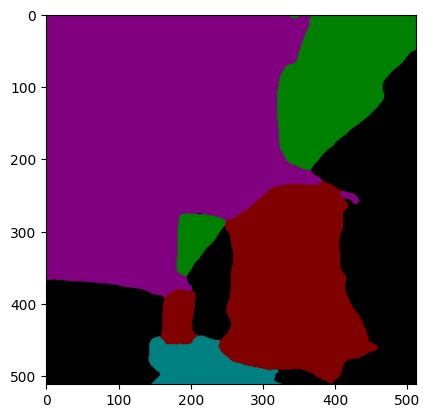

In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

"""
# File      :onnx_infer.py.py
# Date      :2023/9/14 下午8:27
# Author    :konglx
"""

import numpy as np
import onnx
import onnxruntime as ort
import cv2
import torch
from matplotlib import pyplot as plt
# from dataset.semi import normalize
from PIL import Image
from torchvision import transforms
import imgviz


def normalize(img, mask=None):
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    if mask is not None:
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask
    return img


def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

if __name__ == '__main__':
    # onnx_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/demo.onnx'
    onnx_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx'
    img_num = '00000'#'3__1__2772___0'#'00003'#'00002'#'00012'#'1__1__1848___1848'#'00007'#'2__1__1848___924'#'00012'#'2__1__1848___924' #'12__1__924___0'#'152'#'2__1__1848___924' #'1__1__4256___924' # '1__1__3696___924'

    img_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/data/open_dataset_plus_with_my_plus/JPEGImages/%s.jpg' % img_num

    # img_cv2 = cv2.imread(img_dir)
    # print(img_cv2.shape)
    # cv2.imshow('i', img_cv2)
    # # hwc->chw
    # img_chw = img_cv2[:, :, ::-1].transpose((2,0,1))
    # # continuous
    # img_chw = np.ascontiguousarray(img_chw)
    #
    # print(img_chw.shape)
    # # model = onnx.load()
    # # cv2.imshow('j', img_chw)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # 按照dataloader进行数据预处理！！！！！！！！！！
    img_pil = Image.open(img_dir).convert('RGB')


    img_input = normalize(img_pil)
    # 对于onnx需要指定输入的shape
    resize = transforms.Resize([512,512])
    img_input = resize(img_input)
    print(img_input.shape)
    # img_tensor = torch.from_numpy(img_input).type(torch.cuda.FloatTensor)
    img_tensor = img_input.unsqueeze(0).cuda()
    img_np = img_tensor.detach().cpu().numpy()
    print(img_np.shape)
    ort_session = ort.InferenceSession(onnx_dir) # 创建一个推理session

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}

    import time
    start = time.time()
    ort_outs = ort_session.run(None, ort_inputs)[0]
    # 通过 get_inputs()[i].name来获取输入的名称
    end = time.time()
    print("onnx预测时间：", end-start)
    print(ort_outs.shape,  type(ort_outs))
    # print(ort_outs)

    # 输出为4分类，即，c=4的图像，取最大的通道，合并，即为预测图像
    # numpy转torch
    pred = torch.from_numpy(ort_outs)
    pred_softmax = pred.softmax(dim=1).max(dim=1)[1]
    print(pred_softmax.shape)
    # print(pred_softmax)

    pred_np = pred_softmax.numpy()[0]
    # 对预测的mask用colored_mask上色
    pred_pil_np = colored_mask(pred_np)
    pred_np_cls = np.unique(pred_pil_np)
    print(np.unique(pred_np))
    plt.imshow(pred_pil_np)
    plt.show()

In [1]:
################################
# 1.定义分割构件和生成椭圆的函数
################################
from PIL import Image, ImageDraw
import random
from torchvision import transforms
import numpy as np
import onnx
import onnxruntime as ort
import cv2
import torch
from matplotlib import pyplot as plt
# from dataset.semi import normalize
from PIL import Image
from torchvision import transforms
import imgviz



def normalize(img, mask=None):
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    if mask is not None:
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask
    return img


def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil

## 分割构件
def seg_members(onnx_dir, img_pil):
    # 加载模型
    img_input = normalize(img_pil)
    # 对于onnx需要指定输入的shape
    resize = transforms.Resize([512,512])
    img_input = resize(img_input)
    print(img_input.shape)
    # img_tensor = torch.from_numpy(img_input).type(torch.cuda.FloatTensor)
    img_tensor = img_input.unsqueeze(0).cuda()
    img_np = img_tensor.detach().cpu().numpy()
    print(img_np.shape)
    ort_session = ort.InferenceSession(onnx_dir) # 创建一个推理session

    ort_inputs = {ort_session.get_inputs()[0].name: img_np}

    import time
    start = time.time()
    ort_outs = ort_session.run(None, ort_inputs)[0]
    # 通过 get_inputs()[i].name来获取输入的名称
    end = time.time()
    print("onnx预测时间：", end-start)
    print(ort_outs.shape,  type(ort_outs))
    # print(ort_outs)

    # 输出为4分类，即，c=4的图像，取最大的通道，合并，即为预测图像
    # numpy转torch
    pred = torch.from_numpy(ort_outs)
    pred_softmax = pred.softmax(dim=1).max(dim=1)[1]
    print(pred_softmax.shape)
    # print(pred_softmax)

    pred_np = pred_softmax.numpy()[0]
    # 对预测的mask用colored_mask上色
    pred_pil_np = colored_mask(pred_np)
    pred_np_cls = np.unique(pred_np)
    
    return pred_pil_np, pred_np_cls


###### 定义选定区域内生成若干数量的椭圆的腐蚀#######
def generate_ellipse_to_want_area(org_img_np, generate_ellipses, fill_value, want_area = [1,4], num_ellipses=15, a_min=30, a_max=100, b_min=20, b_max=40, split_everywhere=False):
    """
    generate_ellipsepolygon_to_want_area based on function 'generate_polygon'.

    Args:
        org_img_np (numpy.ndarray): The input array.
        generate_polygon (function): generate_polygon
        want_area_list (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1,4].

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing the generated and filled polygon.
    """
    list_area_corrosion = []
    list_area_only_corrosion = []
    for area in want_area:
        gen_polygon, gen_polygon_blank = generate_ellipses(arr=org_img_np, fill_value=fill_value, values=area, num_ellipses=num_ellipses, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, split_everywhere=split_everywhere)
        list_area_corrosion.append(gen_polygon)
        list_area_only_corrosion.append(gen_polygon_blank)
    sum_area = np.sum(list_area_corrosion, axis=0)
    sum_area_only_corrosion = np.sum(list_area_only_corrosion, axis=0)
    return sum_area, list_area_corrosion, sum_area_only_corrosion, list_area_only_corrosion

########### 定义基于numpy选择构件的函数#####

def filter_array(arr, values):
    """
    Filter a NumPy array to keep only the specified values.

    Args:
        arr (numpy.ndarray): The input array to be filtered.
        values (list or tuple): A list or tuple of values to keep in the filtered array.

    Returns:
        numpy.ndarray: A new array with the same shape as the input array,
                       containing only the specified values.
    """
    conditions = [arr == value for value in values]
    condition = np.logical_or.reduce(conditions)
    filtered_arr = np.where(condition, arr, 0)
    return filtered_arr

################### 选择腐蚀类型 ######################
# corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
def corrosionType_to_fill_value(corrosionType):
    fill_value = []
    for i in corrosionType:
        if i==1:
            fill_value.append(12)
        elif i==2:
            fill_value.append(6)
        elif i==3:
            fill_value.append(4)
    return fill_value

# fill_value_list = corrosionType_to_fill_value(corrosionType=corrosionType) # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： 1-fair对应12/12，2-poor对应12/6， 3-severe对应12/4


################### 定义和生成椭圆 ######################
def generate_ellipses(arr, fill_value=1, values=[5], num_ellipses=5, a_min=30, a_max=120, b_min=10, b_max=80, split_everywhere=True):
    """
    🕐用少数量的大椭圆，模拟大片的腐蚀；
    🕑用多数量的小椭圆，模拟pitting corrosion
    Generate random quadrilaterals within the specified regions of a NumPy array
    and fill them with a specified value.

    Args:
        arr (numpy.ndarray): The input array.
        num_polygons (int): The number of quadrilaterals to generate.
        fill_value (int, optional): The value to use for filling the quadrilaterals. Default is 1.
        values (list or tuple, optional): A list or tuple of values to consider as the selected region.
                                          Default is [1].

    Returns:
        tuple(numpy.ndarray): A new array with the same shape as the input array,
                       containing the generated and filled quadrilaterals.
    """
    
    selected_region = np.isin(arr, values)
    # print(selected_region)
    selected_coords = np.argwhere(selected_region)
    print('可选的坐标点数：',len(selected_coords))
    # # 椭圆数量和范围
    # num_ellipses = 5
    # a_min, a_max = 20, 50
    # b_min, b_max = 10, 30
    
    result = arr.copy()
    image = Image.fromarray(result)
    draw = ImageDraw.Draw(image)
    
    # 空白mask
    result_blank = np.zeros_like(result)
    # print(result_blank)
    image_blank = Image.fromarray(result_blank)
    draw_blank = ImageDraw.Draw(image_blank)
    # # 生成图片
    # im = Image.new('RGB', (100,100), color='white')  
    # draw = ImageDraw.Draw(im)
    if split_everywhere:
        for i in range(num_ellipses):
            xy_arr = random.sample(list(selected_coords), k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)
    else:
        selected_coords_with_according_to_num_ellipses_list = []
        xy_arr_0 = random.sample(list(selected_coords), k=1)[0]
        selected_coords_with_according_to_num_ellipses_list.append(xy_arr_0)
        count_num = 0
        for i in list(selected_coords):
            dist = ((i[0]-xy_arr_0[0])**2 + (i[1]-xy_arr_0[1])**2)**0.5
            if dist<= (a_max + b_max):
                selected_coords_with_according_to_num_ellipses_list.append(i)
                xy_arr_0 = i
                count_num += 1
                # print(count_num)
                # print('a')
                if count_num == num_ellipses*3:
                    break
            
        
        # selected_coords_with_according_to_num_ellipses_np = np.array(selected_coords_with_according_to_num_ellipses_list)
        for i in range(num_ellipses):
            xy_arr = random.sample(selected_coords_with_according_to_num_ellipses_list, k=1)
            # print(random.sample(list(selected_coords), k=2), random.sample(list(selected_coords), k=3))
            # print(xy_arr[0][0])
            y, x = xy_arr[0][0], xy_arr[0][1]
            # 随机生成长短半轴
            a = random.randint(a_min, a_max)
            b = random.randint(b_min, b_max)
            
            # 随机中心点
            # x = random.randint(0, 100-a)
            # y = random.randint(0, 100-b)
            
            # 绘制椭圆
            draw.ellipse((x, y, x+a, y+b), fill=fill_value)
            draw_blank.ellipse((x, y, x+a, y+b), fill=fill_value)
        
        result = np.array(image)
        result_mask = np.array(image_blank)

            
    
    return result, result_mask

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 512, 512])
(1, 3, 512, 512)
onnx预测时间： 0.1539468765258789
(1, 12, 512, 512) <class 'numpy.ndarray'>
torch.Size([1, 512, 512])
[[5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [0 1 2 5 6]
[2]
可选的坐标点数： 30226
0 3 [0 3] uint64


/tmp/ipykernel_106182/1195477243.py:38: RuntimeWarning: divide by zero encountered in divide
  mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))
/tmp/ipykernel_106182/1195477243.py:38: RuntimeWarning: invalid value encountered in cast
  mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))


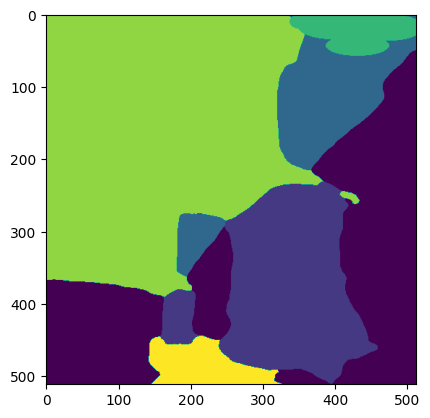

In [6]:
################################
# 2.使用
################################

img_num = '00000'#'3__1__2772___0'#'00003'#'00002'#'00012'#'1__1__1848___1848'#'00007'#'2__1__1848___924'#'00012'#'2__1__1848___924' #'12__1__924___0'#'152'#'2__1__1848___924' #'1__1__4256___924' # '1__1__3696___924'

img_dir = '/home/ubunto/Project/konglx/seg/UniMatch-main/data/open_dataset_plus_with_my_plus/JPEGImages/%s.jpg' % img_num
img_pil = Image.open(img_dir)

pred_pil, pred_np_cls = seg_members(onnx_dir='/home/ubunto/Project/konglx/seg/UniMatch-main/resnet101_se_rand_cut_element.onnx', 
                                       img_pil=img_pil)
print(np.array(pred_pil), pred_np_cls)

## 超参数 ##
# corrosionType = [3] # 腐蚀类型： 1-fair，2-poor， 3-severe
seed = 1
split_everywhere = False
fill_value_setting = 4 # 以12 为填充数据，与memberstype分开，而后再通过corrosionType_to_fill_value返回对应corrosionType
                        # 以12为总数量，fill_value与corrosionType对应：腐蚀类型： fill_value_setting=12:  1-fair对应12/fill_value_setting，
                        #                                                    fill_value_setting=6:   2-poor对应12/fill_value_setting， 
                        #                                                    fill_value_setting=4:   3-severe对应12/fill_value_setting
# 基于预测的类别选择区域

# 定义numpy的随机模式
np.random.seed(seed)
random.seed(seed)

mask_members_np_mode_R = np.array(pred_pil)
select_area_list = [np.random.choice(pred_np_cls[1:])]
print(select_area_list)
# 选择构件区域
mask_members_np_mode_R_filter = filter_array(mask_members_np_mode_R, select_area_list)
# 4.在members指定区域生成任意数量的腐蚀，返回仅仅为腐蚀区域 （生成用）
mask_corrosion_corr_to_members, mask_corrosion_corr_to_members_list, mask_only_corrosion_corr_to_members, mask_only_corrosion_corr_to_members_list = generate_ellipse_to_want_area(org_img_np=mask_members_np_mode_R, generate_ellipses=generate_ellipses, fill_value=fill_value_setting, want_area=select_area_list, split_everywhere=split_everywhere)
plt.imshow(mask_corrosion_corr_to_members)

# mask_only_corrosion_corr_to_members_devide_by_fill_value = (mask_only_corrosion_corr_to_members/fill_value_setting).astype((np.uint64))
mask_only_corrosion_corr_to_members_devide_by_fill_value = (12/mask_only_corrosion_corr_to_members).astype((np.uint64))
print(mask_only_corrosion_corr_to_members_devide_by_fill_value.min(), mask_only_corrosion_corr_to_members_devide_by_fill_value.max(), np.unique(mask_only_corrosion_corr_to_members_devide_by_fill_value), mask_only_corrosion_corr_to_members_devide_by_fill_value.dtype)
# print(np.unique(mask_only_corrosion_corr_to_members/12), mask_only_corrosion_corr_to_members.dtype, ((mask_only_corrosion_corr_to_members/12).astype(np.uint64)).dtype)

mask_only_corrosion_final_pil = colored_mask(mask_only_corrosion_corr_to_members_devide_by_fill_value)
# plt.imshow(mask_only_corrosion_final_pil) 

In [1]:
import gradio as gr
# from gradio import Brush
import time
import imgviz
import numpy as np
import cv2
from PIL import Image

brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # time.sleep(5)
    # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    print('im', im)
    if len(im["layers"]) == 0:
        im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    # im["layers"][0]=cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB )
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    # print(type(im_in), im)
    print('******type(im_in), im_in.shape,im:******', type(im_in), im_in.shape,im)#, type(im), im)
    # if len(im["layers"]) == 0:
    #     im["layers"]=im["layers"].append(np.zeros((512, 512, 4), np.uint8))
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600,width=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600,width=600), background

with gr.Blocks() as demo:
    with gr.Column():
        with gr.Row():
            org_img = gr.Image(type="numpy", label="Original Image")
            
            im = gr.ImageEditor(
                type="numpy",
                crop_size="1:1",
                height=512,
                width=512,
                brush=brush_colors,
            )
    
    with gr.Row():
        
        uploadbtn = gr.Button("image upload")
        savebtn = gr.Button("save")
        uploadbtn.click(upim,[org_img,im],[im])
    
    # im =gr.Sketchpad(type="pil",
    #     crop_size="1:1",)
 
    with gr.Column():
        with gr.Row():
            im_out_1 = gr.Image(type="numpy")
            im_out_2 = gr.Image(type="numpy")
            im_out_3 = gr.Image(type="numpy")
            # im_out_4 = gr.Image(type="numpy")
 
    btn = gr.Button()
    im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
    savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
 
if __name__ == "__main__":
    demo.launch()

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['rgb(128, 0, 0)', 'rgb(0, 128, 0)', 'rgb(128, 128, 0)']
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


******type(im_in), im_in.shape,im:****** <class 'numpy.ndarray'> (512, 512, 3) {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8

In [1]:
import gradio as gr
# from gradio import Brush
import time
import imgviz
import numpy as np
import cv2
from PIL import Image

brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # time.sleep(5)
    # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print(type(im_in), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600), background

with gr.Blocks() as demo:
    with gr.Column():
        with gr.Row():
            org_img = gr.Image(type="numpy", label="Original Image")
            
            im = gr.ImageEditor(
                type="numpy",
                crop_size="1:1",
                height=512,
                width=512,
                brush=brush_colors,
            )
    
    with gr.Row():
        
        uploadbtn = gr.Button("image upload")
        savebtn = gr.Button("save")
        uploadbtn.click(upim,[org_img,im],[im])
    
    # im =gr.Sketchpad(type="pil",
    #     crop_size="1:1",)
 
    with gr.Column():
        with gr.Row():
            im_out_1 = gr.Image(type="numpy")
            im_out_2 = gr.Image(type="numpy")
            im_out_3 = gr.Image(type="numpy")
            # im_out_4 = gr.Image(type="numpy")
 
    btn = gr.Button()
    im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
    savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
 
if __name__ == "__main__":
    demo.launch()

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['rgb(128, 0, 0)', 'rgb(0, 128, 0)', 'rgb(128, 128, 0)']
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


<class 'numpy.ndarray'> {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8), 'layers': [array([[[0, 0, 0, 0],
        [0, 0, 0, 0

In [3]:
import gradio as gr



brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]

with gr.Blocks() as demo:
    img = gr.ImageEditor(
        brush=gr.Brush(
            # default_color="rgb(200, 200, 200)",
            colors=brush_colors.colors,
            color_mode="fixed",

        ),
        interactive=True,
        height=512,
        width=512,
    )

    change_color = gr.Button(
        value="Change color",
    )

    change_color.click(
        fn=lambda brush_colors:  gr.update(
            brush=brush_colors
        ),
        inputs=None,
        outputs=img,
    )
    
    # change_color.click(
    #     fn=lambda: gr.update(
    #         brush=gr.Brush(colors=["rgb(128, 0, 0)", "rgb(200, 200, 255)"], color_mode="fixed")
    #     ),
    #     inputs=None,
    #     outputs=img,
    # )

demo.launch(height=1024)

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/utils.py:1002: UserWarning: Expected 1 arguments for function <function <lambda> at 0x7f65941664c0>, received 0.
  warnings.warn(
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/utils.py:1006: UserWarning: Expected at least 1 arguments for function <function <lambda> at 0x7f65941664c0>, received 0.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/helpers.py:978: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


[  0  50 204]


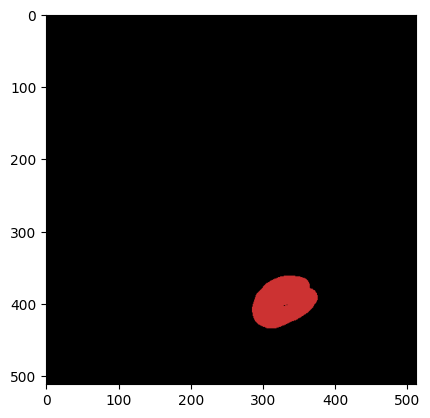

In [11]:
layer_dir = '/home/ubunto/Project/konglx/generate/diffusers/UI/layers0.png'
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the layer image
layer_img = Image.open(layer_dir)

# Convert the image to a numpy array
layer_arr = np.array(layer_img)
print(np.unique(layer_arr))
# Plot the image
plt.imshow(layer_arr)
plt.show()

In [2]:
import gradio as gr
import time
import numpy as np
import cv2

def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    cv2.imwrite("layers0.png",im["layers"][0])
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600), background

def loadimg(im):
    layers0=cv2.imread("layers0.png",-1)
    background=cv2.imread("background.png")
    composite=cv2.imread("composite.png")
    #layers0=cv2.cvtColor(layers0, cv2.COLOR_RGB2BGR, cv2.IMREAD_UNCHANGED )
    background=cv2.cvtColor(background, cv2.COLOR_RGB2BGR )
    composite=cv2.cvtColor(composite, cv2.COLOR_RGB2BGR )
    
    im["layers"][0]=layers0
    im["background"]=background
    im["composite"]=composite
    return gr.ImageMask(value=im,height=600), background

def upim(im_in,im):
    print(type(im_in))
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600)
def getmask(im):
    im.save("i.png")
    #dst = Image.new('RGBA', (im.width + o_img.width, im.height))
    
with gr.Blocks() as demo:
    with gr.Tab("カウント"):
        with gr.Row():
            with gr.Column():
                im_in = gr.Image(sources="upload")
                uploadbtn = gr.Button("image upload")
            with gr.Column():    
                with gr.Row():
                    im = gr.ImageMask(height=600)
                with gr.Row():
                    savebtn = gr.Button("save")
                    loadbtn = gr.Button("load")
                with gr.Accordion():
                    with gr.Row():
                        im2 = gr.Image(height=600)
            uploadbtn.click(upim,[im_in,im],[im])
            savebtn.click(saveimg, outputs=[im, im2], inputs=im)
            
            loadbtn.click(loadimg, outputs=[im, im2], inputs=im)
    with gr.Tab("症例一覧"):
        with gr.Row():
            im3 = gr.Image(height=600)

if __name__ == "__main__":
    demo.queue()
    demo.launch(server_name="0.0.0.0",server_port=8044, root_path="/8044")


Running on local URL:  http://0.0.0.0:8044

To create a public link, set `share=True` in `launch()`.


<class 'numpy.ndarray'>
 shape:(512, 512, 3), ndim:3, size:786432
